<a href="https://colab.research.google.com/github/Giathoai/NEON1/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**California House Price Prediction**

## Giới thiệu bài toán

Dữ liệu được công bố bởi **US Census Bureau** về các block group tại bang California, với 10 đặc trưng khác nhau như:  
- Dân số (population)  
- Thu nhập trung bình (median income)  
- Tuổi trung bình của nhà ở (housing median age)  
- Số phòng, số phòng ngủ, số hộ gia đình,...  
- Khoảng cách tới biển (`ocean_proximity`)  
- Giá nhà trung bình (`median_house_value`)  

Mỗi block group thường có **600 – 3,000 dân số**, và trong dataset này có tổng cộng **20,640 block groups**.

## Mục tiêu
Xây dựng một mô hình **dự đoán giá nhà trung bình tại California** dựa trên các đặc trưng đã cho.  
Cụ thể, mô hình sẽ học từ dữ liệu và dự đoán được giá trị trung vị của một khu vực bất kỳ khi biết: dân số, thu nhập, vị trí địa lý, khoảng cách tới biển, v.v.

## Các mô hình được triển khai
- Linear Regression
- Random Forest
- Support Vector Regression (SVR)
- Multi-layer Perceptron (MLP)

# **0. Khai báo thư viện và tải dataset**

In [ ]:
import kagglehub
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [ ]:
path = kagglehub.dataset_download("shibumohapatra/house-price")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'house-price' dataset.
Path to dataset files: /kaggle/input/house-price


# **1. Khám phá Data**

## **1.1. Đọc dataset**

In [ ]:
df = pd.read_csv(os.path.join(path, "1553768847-housing.csv"))
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


## **1.2. Thông tin chung và Dữ liệu khuyết**

### Review dữ liệu House Price (California Housing Prices)

### 1. Quy mô & cấu trúc
- **Kích thước**: 20.640 bản ghi, 10 cột  
- **Định dạng**: bảng dữ liệu dạng phẳng (`pandas DataFrame`)

### 2. Các thuộc tính
- **Tọa độ**: `longitude`, `latitude`  
- **Nhà cửa**: `housing_median_age`, `total_rooms`, `total_bedrooms`, `households`  
- **Dân cư**: `population`, `median_income`  
- **Phân loại**: `ocean_proximity`  
- **Biến mục tiêu**: `median_house_value`  

### 3. Chất lượng dữ liệu
- Thiếu dữ liệu: chỉ có 207 giá trị thiếu ở `total_bedrooms` (~1%) → dễ xử lý.

In [ ]:
print("Kích thước dataset:", df.shape)

print("Thông tin dữ liệu:")
print(df.info())

print("Số lượng dữ liệu khuyết ở mỗi cột:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing if not missing.empty else "Không có dữ liệu khuyết")

Kích thước dataset: (20640, 10)
Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB
None
Số lượng dữ liệu khuyết ở mỗi cột:
total_bedrooms    207
dtype: int64


## **1.3. Thống kê mô tả**

###Phân tích thống kê mô tả (California Housing Prices)

### 1. Biến số (numerical features)
- **longitude, latitude**  
  Đây là tọa độ địa lý của bang California, với khoảng giá trị khá hẹp (longitude: -124 đến -114, latitude: 32 đến 42). Các giá trị này hợp lý với phạm vi vị trí địa lý thực tế của California, và chủ yếu giúp mô hình nắm được phân bố không gian của các khu dân cư.  

- **housing_median_age**  
  Tuổi trung vị của nhà ở có giá trị trung bình khoảng 29 năm, dao động từ 1 đến 52. Điều này cho thấy dữ liệu bao gồm cả những khu dân cư mới xây lẫn những khu đã lâu đời.  

- **total_rooms**  
  Tổng số phòng trong mỗi khu có trung bình khoảng 2636 phòng. Tuy nhiên, giá trị cực đại lên tới hơn 39,000 phòng, cho thấy tồn tại nhiều **outlier** và phân phối bị lệch.  

- **total_bedrooms**  
  Tổng số phòng ngủ có trung bình khoảng 538, với giá trị cực đại hơn 6000 phòng. Biến này cũng có khoảng 207 giá trị bị thiếu (chiếm ~1%), cần xử lý bằng kỹ thuật **imputation** hoặc loại bỏ trong quá trình tiền xử lý.  

- **population**  
  Số dân trong mỗi block group có giá trị trung bình khoảng 1425 người, nhưng có khu lên tới hơn 35,000 dân. Đây là dấu hiệu của dữ liệu **mất cân bằng và outlier**, cần xem xét log-transform hoặc chuẩn hóa.  

- **households**  
  Số hộ gia đình trung bình khoảng 500, với giá trị cực đại lên tới hơn 6000 hộ. Biến này có phân phối lệch và xuất hiện nhiều outlier tương tự population.  

- **median_income**  
  Thu nhập trung vị được chuẩn hóa (theo đơn vị 10,000 USD), có giá trị trung bình khoảng 3.87 (tức 38,700 USD/năm). Giá trị tối thiểu chỉ 0.5 (~ 5,000 USD) và tối đa khoảng 15 (~ 150,000 USD). Đây là biến giải thích quan trọng nhất cho **giá nhà**, vì thu nhập thường tương quan mạnh với khả năng chi trả.  

- **median_house_value (target)**  
  Giá nhà trung vị (USD) có giá trị trung bình khoảng 207,000, dao động từ 14,999 đến 500,001. Lưu ý: giá trị 500,001 bị **giới hạn trên (capped)** nên có thể gây sai lệch nếu không xử lý. Phân phối lệch phải (skewed), tức là nhiều khu có giá thấp và ít khu có giá rất cao.  

### 2. Biến phân loại (categorical feature)
- **ocean_proximity**  
  Biến phân loại với 5 nhóm: `<1H OCEAN`, `INLAND`, `NEAR BAY`, `NEAR OCEAN`, `ISLAND`. Trong đó, nhóm `<1H OCEAN` phổ biến nhất (9136 bản ghi, chiếm khoảng 44%). Vị trí gần biển thường ảnh hưởng mạnh đến giá trị bất động sản, nên biến này rất quan trọng khi dự đoán giá nhà.  


In [ ]:
print("Thống kê biến numerical:")
display(df.describe().transpose())

print("Thống kê biến categorical:")
display(df.describe(include=["object"]).transpose())

Thống kê biến numerical:


,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


Thống kê biến categorical:


,count,unique,top,freq
ocean_proximity,20640,5,<1H OCEAN,9136


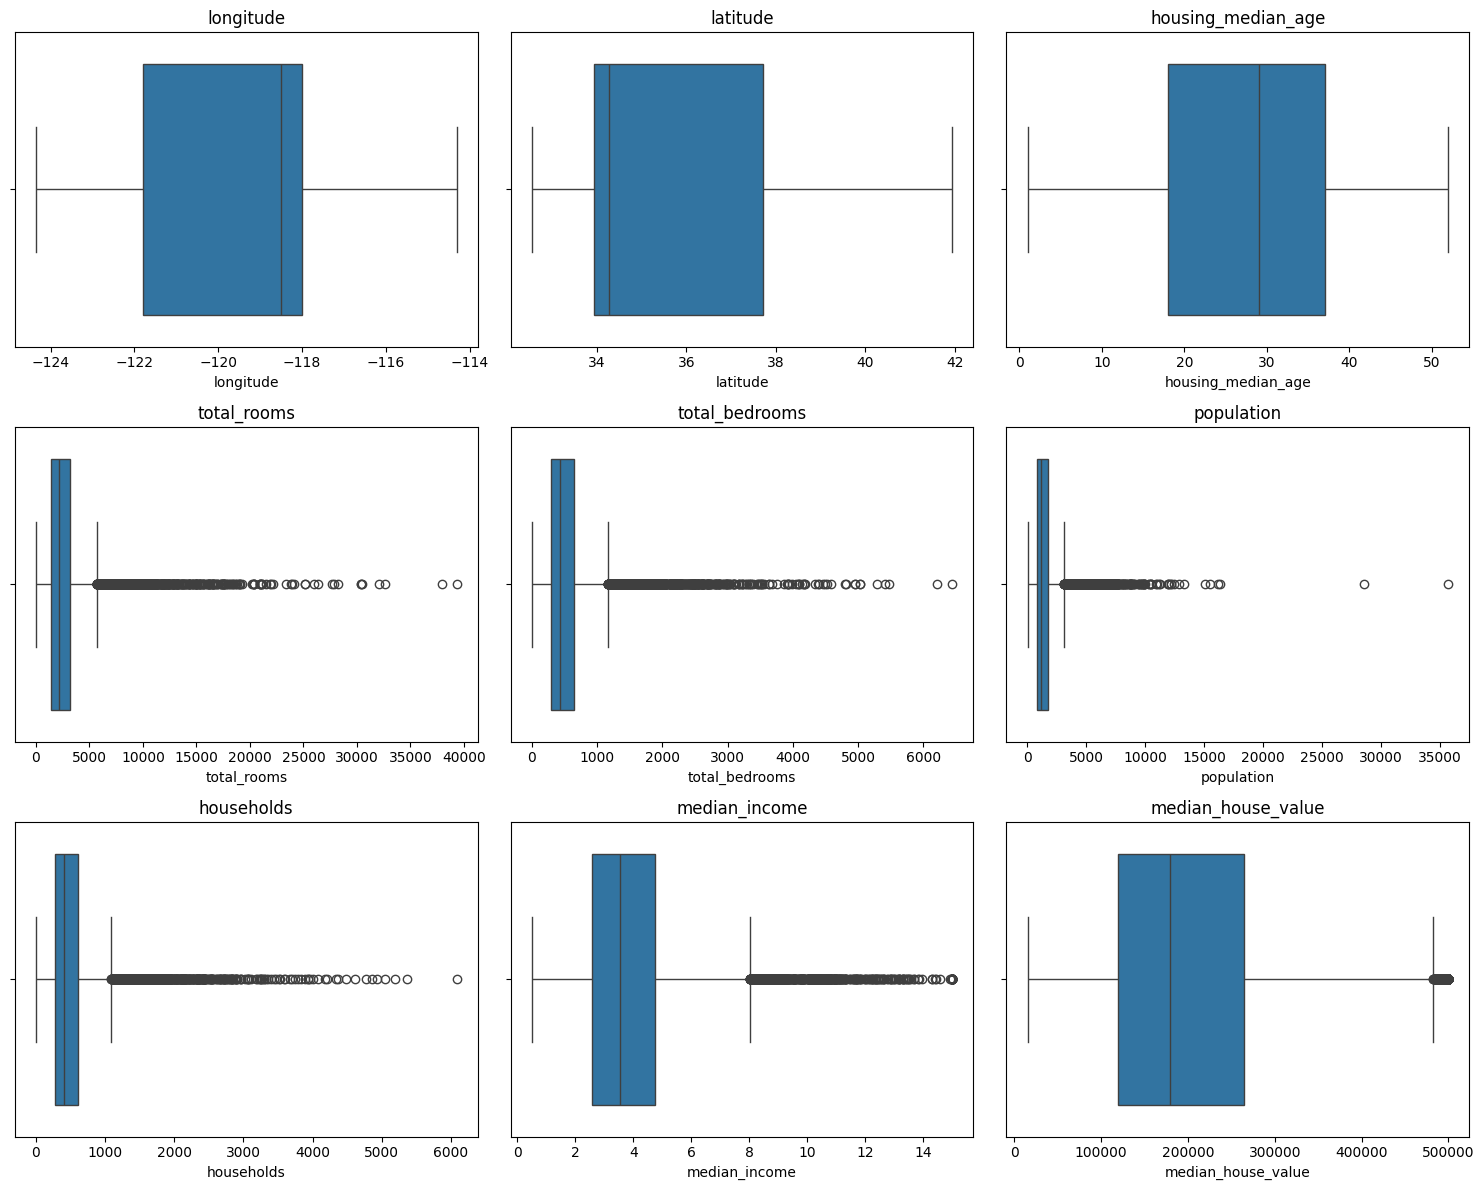

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns

n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*5, rows*4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

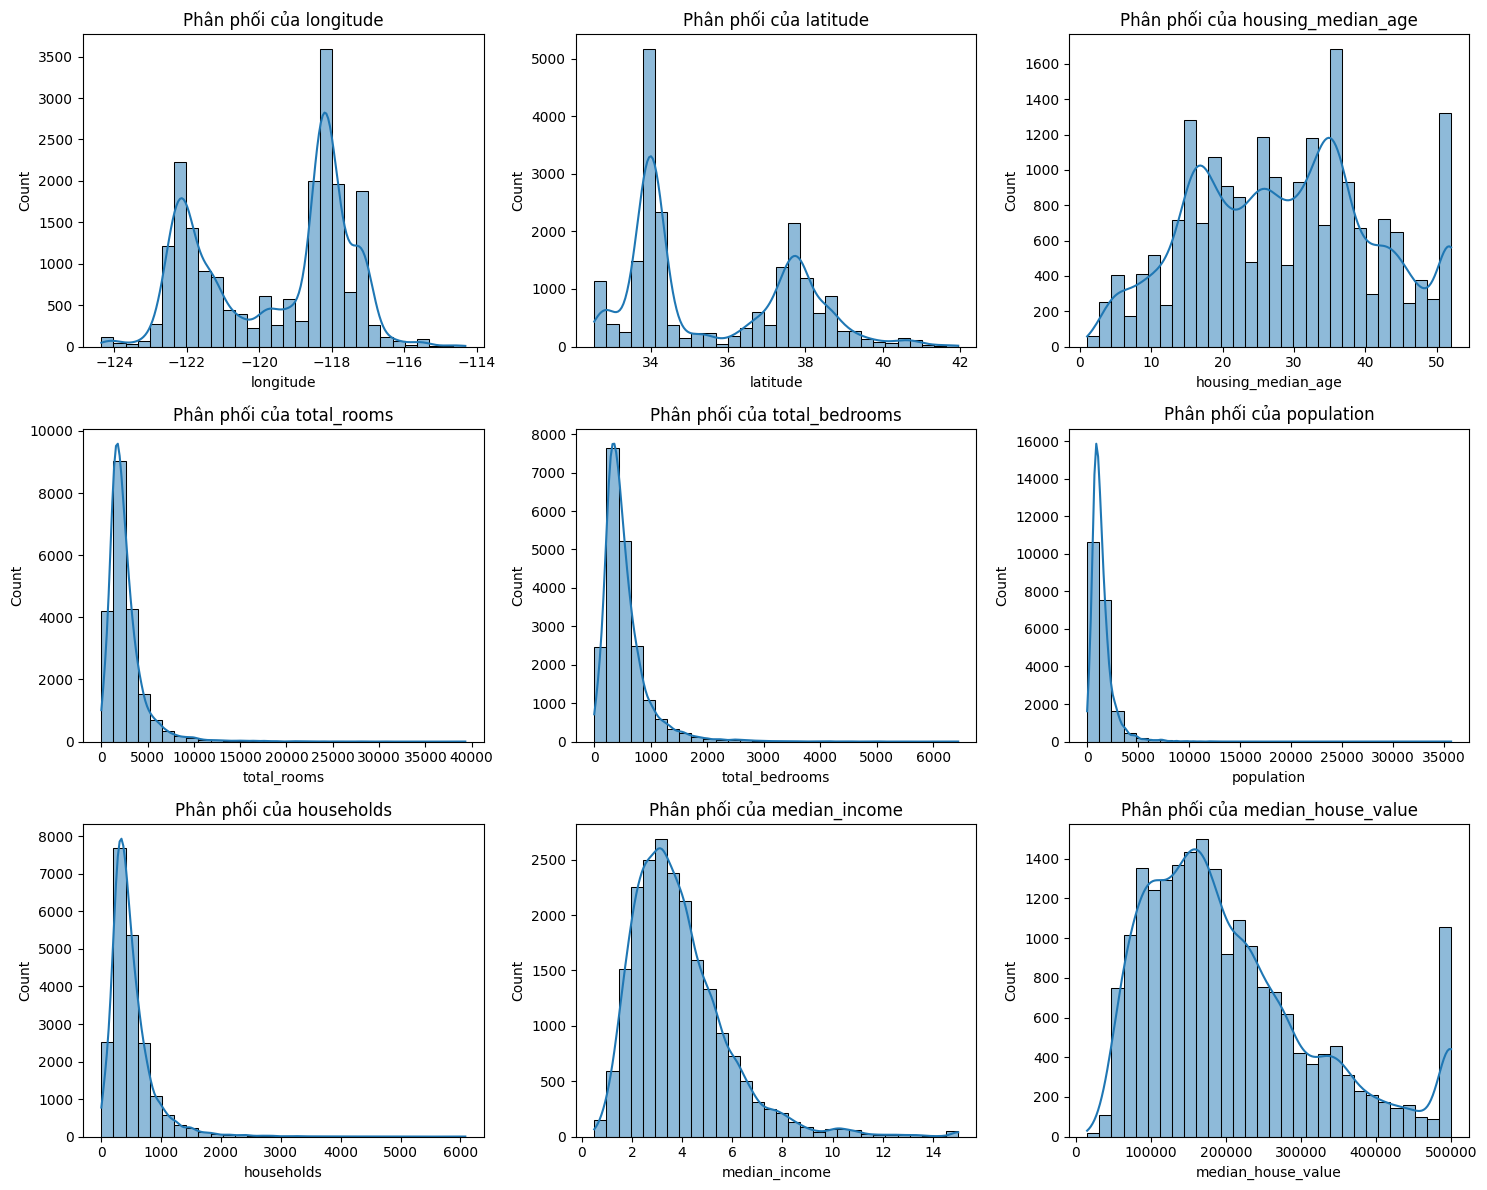

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns

n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*5, rows*4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f"Phân phối của {col}")

plt.tight_layout()
plt.show()

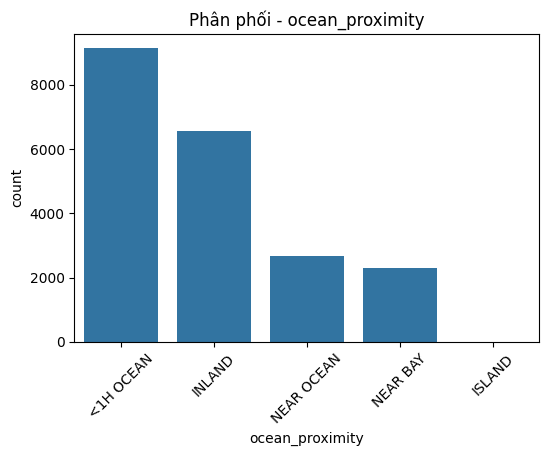

In [ ]:
cat_cols = df.select_dtypes(include=["object"]).columns

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.title(f"Phân phối - {col}")
    plt.xticks(rotation=45)
    plt.show()

# **2. Pipeline ML truyền thống**

##**2.1. Xử lý dữ liệu**

### Xử lý giá trị thiếu (Missing Values)
Trong bộ dữ liệu California Housing, một số bản ghi có giá trị thiếu, điển hình là **`total_bedrooms`** với khoảng 207 giá trị trống (~1% tổng số bản ghi).

Do tỷ lệ missing thấp, chúng ta có thể **loại bỏ các bản ghi này** để đảm bảo dữ liệu sạch cho phân tích thống kê và xây dựng mô hình dự đoán giá nhà.

Sau khi loại bỏ, tập dữ liệu còn lại 20433 samples **không chứa giá trị missing**, giúp việc phân tích và huấn luyện mô hình trở nên thuận tiện và chính xác hơn.

In [ ]:
df_filtered = df.dropna()
df_filtered

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


### Lọc Outliers trong bộ dữ liệu California Housing

Sau khi loại bỏ các samples chứa giá trị missing, bước tiếp theo là kiểm tra và xử lý **outliers** – những giá trị bất thường có thể ảnh hưởng đến phân tích thống kê và hiệu quả dự đoán của mô hình.

Trong bộ dữ liệu này, các biến số liên tục như `total_rooms`, `total_bedrooms`, `population`, `households` và `median_house_value` có khả năng xuất hiện outliers. Chúng ta sẽ sử dụng **IQR (Interquartile Range)** để xác định và loại bỏ các giá trị bất thường:

- Tính Q1 (25th percentile) và Q3 (75th percentile) của mỗi biến.  
- Tính **IQR = Q3 - Q1**.  
- Xác định khoảng hợp lệ:  
  **Lower Bound** = Q1 - 1.5 \times IQR, **Upper Bound** = Q3 + 1.5 \times IQR

- Loại bỏ các samples chứa giá trị nằm ngoài khoảng này.

Sau khi loại bỏ các samples chứa giá trị outliers, tập dữ liệu còn 16724 samples.

In [ ]:
for col in num_cols:
    Q1 = df_filtered[col].quantile(0.25)
    Q3 = df_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]

df = df_filtered
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
5,-122.25,37.85,52,919,213.0,413,193,4.0368,NEAR BAY,269700
6,-122.25,37.84,52,2535,489.0,1094,514,3.6591,NEAR BAY,299200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


### Tiền xử lý dữ liệu (Data Preprocessing)

Sau khi đã loại bỏ giá trị missing và outliers, bước tiếp theo là **tiền xử lý dữ liệu** để chuẩn bị cho việc huấn luyện mô hình dự đoán giá nhà.

1. **Tách biến đầu vào và biến mục tiêu**  
   - `X` chứa tất cả các biến đầu vào (features).  
   - `y` là biến mục tiêu `median_house_value`, **chia giá trị biến này cho 1000 để đưa giá trị về phạm vi nhỏ hơn, giúp mô hình (nhất là MLP) học ổn định và hội tụ nhanh hơn**.

2. **Chia dữ liệu thành tập huấn luyện và tập kiểm tra**  
   - 80% dữ liệu được sử dụng để huấn luyện, 20% để kiểm tra mô hình.  
   - Việc chia dữ liệu ngẫu nhiên nhưng có `random_state` đảm bảo kết quả có thể tái lập.

3. **Phân loại các biến số**  
   - Biến **numerical**: kiểu số, bao gồm cả những biến cần áp dụng **log-transform** (`total_rooms`, `total_bedrooms`, `population`, `households`, `median_income`) để giảm ảnh hưởng của outliers và các phân phối lệch phải.  
   - Biến **categorical**: kiểu phân loại, sẽ được xử lý bằng phương pháp **one-hot encoding**.

4. **Xây dựng pipeline tiền xử lý**  
   - Biến numerical log-transform: áp dụng log-transform và chuẩn hóa Min-Max.  
   - Biến numerical khác: chỉ chuẩn hóa Min-Max.  
   - Biến categorical: áp dụng one-hot encoding, đảm bảo các giá trị mới trong tập kiểm tra không gây lỗi.

Sau khi áp dụng pipeline tiền xử lý, dữ liệu đã được **chuẩn hóa, log-transform và one-hot encoding**, sẵn sàng cho các bước huấn luyện mô hình Machine Learning dự đoán giá nhà.

In [ ]:
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"] / 1000

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_log_cols = ["total_rooms", "total_bedrooms", "population", "households", "median_income"]
num_other_cols = [col for col in num_cols if col not in num_log_cols]
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

log_transformer = Pipeline(steps=[
    ("log", FunctionTransformer(np.log1p)),
    ("scaler", MinMaxScaler())
])

num_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_other_cols),
        ("num_log", log_transformer, num_log_cols),
        ("cat", cat_transformer, cat_cols)
    ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## **2.2. Các mô hình Machine Learning**





### Linear Regression (Hồi quy tuyến tính)

Hồi quy tuyến tính là một trong những thuật toán học máy giám sát đơn giản và phổ biến nhất. Mục tiêu của nó là dự đoán giá trị của một biến phụ thuộc (biến mục tiêu) dựa trên một hoặc nhiều biến độc lập (đặc trưng) bằng cách tìm một mối quan hệ tuyến tính giữa chúng.  




**Thông số đầu vào:**

In [ ]:
PCA_lr = [None, 0.9]

*trong đó:*
- PCA_lr: list, các lựa chọn PCA trong pipeline

**Mô hình**

In [ ]:
results_lr = []


for pca_comp in PCA_lr:
    pipe_lr = Pipeline(steps=[
        ("pca", PCA(n_components=pca_comp) if pca_comp else "passthrough"),
        ("model", LinearRegression())
    ])

    pipe_lr.fit(X_train, y_train)
    y_pred_lr = pipe_lr.predict(X_test)

    results_lr.append({
      "Model": "LinearRegression",
      "PCA": "None" if pca_comp is None else pca_comp,
      "MAE": mean_absolute_error(y_test, y_pred_lr),
      "MSE": mean_squared_error(y_test, y_pred_lr),
      "R2": r2_score(y_test, y_pred_lr)
  })

df_results_lr = pd.DataFrame(results_lr)
df_results_rf_style = df_results_lr.style.apply(lambda x: ['background: red' if x.name == 'MAE' else '' for i in x], axis=1)
df_results_rf_style

,Model,PCA,MAE,MSE,R2
0,LinearRegression,None,44.073279,3403.176560,0.602164
1,LinearRegression,0.900000,58.957967,5900.362181,0.310239


### Random Forest

Random Forest là một thuật toán học máy mạnh mẽ thuộc nhóm ensemble learning, sử dụng nhiều cây quyết định (decision tree) để đưa ra dự đoán. Mỗi cây được huấn luyện trên một mẫu ngẫu nhiên của dữ liệu và chọn ngẫu nhiên các đặc trưng khi tách nhánh.  

Khi dự đoán, Random Forest kết hợp kết quả của tất cả các cây (bằng trung bình đối với bài toán hồi quy hoặc bỏ phiếu đa số đối với bài toán phân loại) để đưa ra kết quả cuối cùng. Phương pháp này giúp giảm hiện tượng **overfitting**, tăng độ chính xác và khả năng khái quát hóa của mô hình.


**Thông số đầu vào:**

In [ ]:
ns = [100, 200]
depths = [None, 10]
PCA_rf = [None, 0.9]

*trong đó:*
- ns: list, các lựa chọn số lượng cây (n_estimators) cho RandomForest  
- depths: list, các lựa chọn độ sâu tối đa (max_depth) cho RandomForest  
- PCA_rf: list, các lựa chọn PCA trước khi dùng RandomForest  

**Mô hình**

In [ ]:
results_rf = []

for n in ns:
    for depth in depths:
        for pca_comp in PCA_rf:
            pipe_rf = Pipeline(steps=[
                ("pca", PCA(n_components=pca_comp) if pca_comp else "passthrough"),
                ("model", RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=42))
            ])

            pipe_rf.fit(X_train, y_train)
            y_pred_rf = pipe_rf.predict(X_test)

            model_name = f"RandomForest(n={n}, depth={'None' if depth is None else depth})"

            results_rf.append({
                "Model": model_name,
                "PCA": "None" if pca_comp is None else pca_comp,
                "MAE": mean_absolute_error(y_test, y_pred_rf),
                "MSE": mean_squared_error(y_test, y_pred_rf),
                "R2": r2_score(y_test, y_pred_rf)
            })

df_results_rf = pd.DataFrame(results_rf)
df_results_rf_style = df_results_rf.style.apply(lambda x: ['background: red' if x.name == 'MAE' else '' for i in x], axis=1)
df_results_rf_style

,Model,PCA,MAE,MSE,R2
0,"RandomForest(n=100, depth=None)",None,29.306635,1852.824821,0.783402
1,"RandomForest(n=100, depth=None)",0.900000,39.779829,3000.938993,0.649186
2,"RandomForest(n=100, depth=10)",None,32.563052,2140.322446,0.749793
3,"RandomForest(n=100, depth=10)",0.900000,43.286572,3546.328453,0.585429
4,"RandomForest(n=200, depth=None)",None,29.132249,1829.066561,0.786179
5,"RandomForest(n=200, depth=None)",0.900000,39.708751,2986.878723,0.650829
6,"RandomForest(n=200, depth=10)",None,32.455407,2124.808382,0.751607
7,"RandomForest(n=200, depth=10)",0.900000,43.294474,3540.987261,0.586053


### Support Vector Regression (SVR)

Support Vector Regression (SVR) là phiên bản hồi quy của thuật toán Support Vector Machine (SVM). SVR cố gắng tìm một hàm dự đoán sao cho sai số giữa giá trị dự đoán và giá trị thực tế nằm trong một ngưỡng cho phép, đồng thời vẫn giữ mô hình đơn giản và tổng quát.  

SVR sử dụng các **kernel** để biến đổi dữ liệu đầu vào, giúp mô hình có thể học các quan hệ phi tuyến giữa đặc trưng và biến mục tiêu. Thuật toán này thường được sử dụng trong các bài toán hồi quy có dữ liệu phức tạp hoặc phi tuyến.


**Tham số đầu vào:**

In [ ]:
Cs = [1, 10]
kernels = ["linear", "rbf"]
PCA_svr = [None, 0.9]

*trong đó:*
- Cs: list, các giá trị C (tham số điều chỉnh độ phạt lỗi) cho SVR  
- kernels: list, các loại kernel cho SVR  
- PCA_svr: list, các lựa chọn PCA trước khi dùng SVR

**Mô hình**

In [ ]:
results_svr = []

for C in Cs:
    for kernel in kernels:
        for pca_comp in PCA_svr:
            pipe_svr = Pipeline(steps=[
                ("pca", PCA(n_components=pca_comp) if pca_comp else "passthrough"),
                ("model", SVR(C=C, kernel=kernel))
            ])

            pipe_svr.fit(X_train, y_train)
            y_pred_svr = pipe_svr.predict(X_test)

            model_name = f"SVR(C={C}, kernel={kernel})"

            results_svr.append({
                "Model": model_name,
                "PCA": "None" if pca_comp is None else pca_comp,
                "MAE": mean_absolute_error(y_test, y_pred_svr),
                "MSE": mean_squared_error(y_test, y_pred_svr),
                "R2": r2_score(y_test, y_pred_svr)
            })

df_results_svr = pd.DataFrame(results_svr)
df_results_svr_style = df_results_svr.style.apply(lambda x: ['background: red' if x.name == 'MAE' else '' for i in x], axis=1)
df_results_svr_style

,Model,PCA,MAE,MSE,R2
0,"SVR(C=1, kernel=linear)",None,46.176664,4092.247053,0.521610
1,"SVR(C=1, kernel=linear)",0.900000,57.591372,6121.331110,0.284407
2,"SVR(C=1, kernel=rbf)",None,46.053778,4222.517878,0.506381
3,"SVR(C=1, kernel=rbf)",0.900000,55.623500,5902.190664,0.310025
4,"SVR(C=10, kernel=linear)",None,44.008602,3650.009968,0.573308
5,"SVR(C=10, kernel=linear)",0.900000,57.567463,6113.222040,0.285355
6,"SVR(C=10, kernel=rbf)",None,40.305133,3249.117333,0.620173
7,"SVR(C=10, kernel=rbf)",0.900000,50.971027,5131.326008,0.400140


##**2.3. Mô hình Deep Learning**

### Multi-Layer Perceptron (MLP)

Multi-Layer Perceptron (MLP) là một loại mạng nơ-ron nhân tạo phổ biến trong học sâu, dùng cho cả bài toán hồi quy và phân loại. MLP gồm nhiều lớp: một lớp đầu vào, một hoặc nhiều lớp ẩn, và một lớp đầu ra.  

Mỗi lớp gồm nhiều nút (neurons), kết nối với các nút ở lớp tiếp theo thông qua các **trọng số (weights)** và **hàm kích hoạt (activation function)**. MLP học cách dự đoán bằng cách điều chỉnh các trọng số thông qua thuật toán **backpropagation** để giảm sai số giữa giá trị dự đoán và giá trị thực tế.  

MLP đặc biệt hữu ích khi dữ liệu có mối quan hệ phi tuyến và phức tạp mà các mô hình tuyến tính không thể nắm bắt.

**Tham số đầu vào:**

In [ ]:
mlp_configs = [
    {"hidden_layer_sizes": (32,), "activation": "relu", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (64,), "activation": "tanh", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (128,), "activation": "logistic", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (256,), "activation": "relu", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (128, 64), "activation": "tanh", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (256, 128), "activation": "logistic", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (128, 32), "activation": "relu", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (256, 128, 64), "activation": "logistic", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "solver": "adam", "learning_rate_init": 0.05},
    {"hidden_layer_sizes": (512, 256, 128), "activation": "tanh", "solver": "adam", "learning_rate_init": 0.05}
]

*trong đó:*
- mlp_configs: lưu các cấu hình khác nhau của MLPRegressor để thử nghiệm trong pipeline. Cấu trúc dictionary (key-value):
  - `hidden_layer_sizes`: tuple, số lượng neuron ở từng tầng ẩn.  
    - Ví dụ `(128, 64)` nghĩa là 2 tầng ẩn: tầng 1 có 128 neuron, tầng 2 có 64 neuron.  
  - `activation`: chuỗi, hàm kích hoạt của các neuron.  
    - `"relu"` → hàm ReLU  
    - `"tanh"` → hàm tanh  
    - `"logistic"` → hàm sigmoid  
  - `solver`: chuỗi, thuật toán tối ưu hóa trọng số.  
    - `"adam"` → thuật toán Adam  
  - `learning_rate_init`: số thực, tốc độ học khởi tạo (initial learning rate).  
    - Ví dụ: `0.05`

**Mô hình**

In [ ]:
results_mlp = []

for config in mlp_configs:
    mlp_pipe = Pipeline(steps=[
        ("mlp", MLPRegressor(max_iter=1000, random_state=42, **config))
    ])

    mlp_pipe.fit(X_train, y_train)
    y_pred = mlp_pipe.predict(X_test)

    results_mlp.append({
        "Model": f"MLP(hidden={config['hidden_layer_sizes']}, act={config['activation']}, "
                 f"solver={config['solver']}, lr={config['learning_rate_init']})",
        "PCA": "None",
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    })

df_results_mlp = pd.DataFrame(results_mlp)
df_results_mlp_style = df_results_mlp.style.apply(lambda x: ['background: red' if x.name == 'MAE' else '' for i in x], axis=1)
df_results_mlp_style

,Model,PCA,MAE,MSE,R2
0,"MLP(hidden=(32,), act=relu, solver=adam, lr=0.05)",None,37.715572,2729.587641,0.680907
1,"MLP(hidden=(64,), act=tanh, solver=adam, lr=0.05)",None,35.737094,2406.658006,0.718658
2,"MLP(hidden=(128,), act=logistic, solver=adam, lr=0.05)",None,32.997494,2193.305718,0.743599
3,"MLP(hidden=(256,), act=relu, solver=adam, lr=0.05)",None,37.419120,2730.944257,0.680749
4,"MLP(hidden=(128, 64), act=tanh, solver=adam, lr=0.05)",None,74.373751,8556.153097,-0.000227
5,"MLP(hidden=(256, 128), act=logistic, solver=adam, lr=0.05)",None,74.096209,8554.608521,-0.000046
6,"MLP(hidden=(128, 32), act=relu, solver=adam, lr=0.05)",None,35.457721,2454.474769,0.713068
7,"MLP(hidden=(64, 32), act=tanh, solver=adam, lr=0.05)",None,74.123404,8554.391340,-0.000021
8,"MLP(hidden=(256, 128, 64), act=logistic, solver=adam, lr=0.05)",None,73.981056,8556.611905,-0.000281
9,"MLP(hidden=(128, 64, 32), act=relu, solver=adam, lr=0.05)",None,35.882042,2458.983851,0.712541


## **2.4. Đánh giá các mô hình**

In [ ]:
df_all_results = pd.concat([df_results_lr, df_results_rf, df_results_svr, df_results_mlp], ignore_index=True)

for col in ["MAE", "MSE", "R2"]:
    df_all_results[col] = df_all_results[col].astype(float)

df_all_results_style = df_all_results.style.apply(lambda x: ['background: red' if x.name == 'MAE' else '' for i in x], axis=1)
df_all_results_style

,Model,PCA,MAE,MSE,R2
0,LinearRegression,None,44.073279,3403.176560,0.602164
1,LinearRegression,0.900000,58.957967,5900.362181,0.310239
2,"RandomForest(n=100, depth=None)",None,29.306635,1852.824821,0.783402
3,"RandomForest(n=100, depth=None)",0.900000,39.779829,3000.938993,0.649186
4,"RandomForest(n=100, depth=10)",None,32.563052,2140.322446,0.749793
5,"RandomForest(n=100, depth=10)",0.900000,43.286572,3546.328453,0.585429
6,"RandomForest(n=200, depth=None)",None,29.132249,1829.066561,0.786179
7,"RandomForest(n=200, depth=None)",0.900000,39.708751,2986.878723,0.650829
8,"RandomForest(n=200, depth=10)",None,32.455407,2124.808382,0.751607
9,"RandomForest(n=200, depth=10)",0.900000,43.294474,3540.987261,0.586053


In [ ]:
best_mae = df_all_results.loc[df_all_results["MAE"].idxmin()]
best_mse = df_all_results.loc[df_all_results["MSE"].idxmin()]
best_r2 = df_all_results.loc[df_all_results["R2"].idxmax()]
print("Model tốt nhất theo MAE")
print(best_mae)
print("Model tốt nhất theo MSE")
print(best_mse)
print("Model tốt nhất theo R2")
print(best_r2)

Model tốt nhất theo MAE
Model    RandomForest(n=200, depth=None)
PCA                                 None
MAE                            29.132249
MSE                          1829.066561
R2                              0.786179
Name: 6, dtype: object
Model tốt nhất theo MSE
Model    RandomForest(n=200, depth=None)
PCA                                 None
MAE                            29.132249
MSE                          1829.066561
R2                              0.786179
Name: 6, dtype: object
Model tốt nhất theo R2
Model    RandomForest(n=200, depth=None)
PCA                                 None
MAE                            29.132249
MSE                          1829.066561
R2                              0.786179
Name: 6, dtype: object


### Kết luận

Dựa trên kết quả đánh giá, **Random Forest** với 200 cây và không sử dụng PCA là mô hình tốt nhất cho tập dữ liệu này. Mô hình này đạt các chỉ số:  

- **MAE:** 29.13  
- **MSE:** 1829.07  
- **R²:** 0.786  

Các chỉ số này đều là tốt nhất trong tất cả các model đã test.
